In [86]:
import random
import os
import urllib3
import pandas as pd
import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np

COMMON_DIR = os.path.join(os.pardir, 'common')
sys.path.insert(1, COMMON_DIR)

from madison_coordinates import madisonCoordinateToLatLon
import data_retreiver
print(dir(data_retreiver))

[&#39;DATASETS&#39;, &#39;DATA_PATH&#39;, &#39;__builtins__&#39;, &#39;__cached__&#39;, &#39;__doc__&#39;, &#39;__file__&#39;, &#39;__loader__&#39;, &#39;__name__&#39;, &#39;__package__&#39;, &#39;__spec__&#39;, &#39;download_datasets&#39;, &#39;download_file&#39;, &#39;load_csv_datasets&#39;, &#39;os&#39;, &#39;pd&#39;, &#39;urllib3&#39;]


In [2]:
data_retreiver.download_datasets()

In [2]:
(raw, single_fam_locations, all_locations) = data_retreiver.load_csv_datasets("all_parcel_raw", "single_family_locations", "all_parcel_locations")
raw["Parcel"] = raw["Parcel"].astype("str")
print(raw.dtypes)
raw.set_index("Parcel", inplace = True)
all_locations["Parcel"] = all_locations["Parcel"].astype("str")
all_locations.set_index("Parcel", inplace=True)


print("Yo")

raw

OBJECTID                 int64
Parcel                  object
XRefParcel               int64
Address                 object
DateParcelChanged       object
                        ...   
MaxConstructionYear      int64
XCoord                 float64
YCoord                 float64
SHAPESTArea            float64
SHAPESTLength          float64
Length: 143, dtype: object
Yo


OBJECTID   XRefParcel                 Address  \
Parcel                                                       
71002107665         1  71002104033  121 Metro Ter Unit 109   
71002107673         2  71002104033  121 Metro Ter Unit 201   
71002107681         3  71002104033  121 Metro Ter Unit 202   
71002107699         4  71002104033  121 Metro Ter Unit 203   
71002107706         5  71002104033  121 Metro Ter Unit 204   
...               ...          ...                     ...   
71002107615     80162  71002104033  121 Metro Ter Unit 104   
71002107623     80163  71002104033  121 Metro Ter Unit 105   
71002107631     80164  71002104033  121 Metro Ter Unit 106   
71002107649     80165  71002104033  121 Metro Ter Unit 107   
71002107657     80166  71002104033  121 Metro Ter Unit 108   

                  DateParcelChanged PropertyClass  PropertyUse  \
Parcel                                                           
71002107665  2020/06/03 00:00:00+00   Residential  Condominium   
71002107673  2020/06/03 00:00:00+00   Residential  Condominium   
71002107681  2020/06/03 00:00:00+00   Residential  Condominium   
71002107699  2020/06/03 00:00:00+00   Residential  Condominium   
71002107706  2020/06/03 00:00:00+00   Residential  Condominium   
...                             ...           ...          ...   
71002107615  2020/06/03 00:00:00+00   Residential  Condominium   
71002107623  2020/06/03 00:00:00+00   Residential  Condominium   
71002107631  2020/06/03 00:00:00+00   Residential  Condominium   
71002107649  2020/06/03 00:00:00+00   Residential  Condominium   
71002107657  2020/06/03 00:00:00+00   Residential  Condominium   

             AssessmentArea                  AreaName MoreThanOneBuild  \
Parcel                                                                   
71002107665            5115  Condominiums in Area 115              NaN   
71002107673            5115  Condominiums in Area 115              NaN   
71002107681            5115  Condominiums in Area 115              NaN   
71002107699            5115  Condominiums in Area 115              NaN   
71002107706            5115  Condominiums in Area 115              NaN   
...                     ...                       ...              ...   
71002107615            5115  Condominiums in Area 115              NaN   
71002107623            5115  Condominiums in Area 115              NaN   
71002107631            5115  Condominiums in Area 115              NaN   
71002107649            5115  Condominiums in Area 115              NaN   
71002107657            5115  Condominiums in Area 115              NaN   

            HomeStyle  ...  StreetID  StormOutfall  FireDemandZone  \
Parcel                 ...                                           
71002107665    Garden  ...      5686           NaN               0   
71002107673    Garden  ...      5686           NaN               0   
71002107681    Garden  ...      5686           NaN               0   
71002107699    Garden  ...      5686           NaN               0   
71002107706    Garden  ...      5686           NaN               0   
...               ...  ...       ...           ...             ...   
71002107615    Garden  ...      5686           NaN               0   
71002107623    Garden  ...      5686           NaN               0   
71002107631    Garden  ...      5686           NaN               0   
71002107649    Garden  ...      5686           NaN               0   
71002107657    Garden  ...      5686           NaN               0   

             FireDemandSubZone      PropertyChangeDate  MaxConstructionYear  \
Parcel                                                                        
71002107665                  0  1970/01/01 00:00:00+00                 2006   
71002107673                  0  1970/01/01 00:00:00+00                 2006   
71002107681                  0  1970/01/01 00:00:00+00                 2006   
71002107699                  0  1970/01/01 00:00:00+00                 2006   

### TruePropertyClasses:
* Single Family
    * `raw["PropertyClass"] == "Residential", raw["PropertyUse"] == "Single Family"`
* Industrial
    * `raw["PropertyClass"] == "Industrial", raw["PropertyUse"] == "Manufacturing"`
* Appartment
    * Has "unit" in `raw["PropertyUse"]`
* Commercial (Non-Appartment)
    * `raw["PropertyClass"] == "Commercial"` AND not in any other class.
* Agricultural
    * `raw["PropertyClass"] == "Agricultural", raw["PropertyUse"] == "Agricultural"`
* Vacant
    * Has "vacant" in `raw["PropertyUse"]`



In [9]:
def property_kind(property_class, property_use):
    if(not isinstance(property_use, str)):
        print("uncategorized", property_class, property_use)
        return "uncategorized"
    if(property_class == "Residential" and property_use == "Single family"):
        return "single_family_home"
    if(property_class == "Residential" and property_use == "Condominium"):
        return "condo"
    if(property_class == "Industrial" and property_use == "Manufacturing"):
        return "industrial"
    if(property_class == "Agricultural" and property_use == "Agricultural"):
        return "agricultural"
    if("unit" in property_use.lower()):
        return "multi_unit"
    if("vacant" in property_use.lower()):
        return "vacant"
    if(property_class == "Commercial"):
        return "commercial"
    print("uncategorized", property_class, property_use)
    return "uncategorized"

property_kind_df = pd.DataFrame(columns=["Parcel", "property_kind"])
property_kind_df.set_index("Parcel")

row_num = 0
for i, parcel_record in raw.iterrows():
    if(row_num % 4000 == 0):
        print(row_num / 80500)
    row_num += 1
    #print(i, parcel_record["PropertyClass"], parcel_record["PropertyUse"])
    kind = property_kind(parcel_record["PropertyClass"], parcel_record["PropertyUse"])
    record = {"Parcel": i, "property_kind": kind}
    property_kind_df = property_kind_df.append(record, ignore_index=True)
property_kind_df



0.0
0.049689440993788817
uncategorized Residential Other
uncategorized Residential Other
0.09937888198757763
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
0.14906832298136646
0.19875776397515527
uncategorized Residential Other
uncategorized Residential Other
0.2484472049689441
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
0.2981366459627329
uncategorized Residential Other
0.34782608695652173
0.39751552795031053
0.4472049689440994
uncategorized Residential Other
0.4968944099378882
uncategorized Residential Other
uncategorized Residential Other
0.546583850931677
0.5962732919254659
uncategorized Residential Other
0.6459627329192547
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
uncategorized Residential Other
0.69565

Parcel property_kind
0      71002107665         condo
1      71002107673         condo
2      71002107681         condo
3      71002107699         condo
4      71002107706         condo
...            ...           ...
80161  71002107615         condo
80162  71002107623         condo
80163  71002107631         condo
80164  71002107649         condo
80165  71002107657         condo

[80166 rows x 2 columns]

In [27]:
def getLatLonPairs(df):
    result = []
    for pid, record in df.iterrows():
        lat = record["lat"]
        lon = record["lon"]
        result.append((lat, lon))
    return result
    

def getNumNearProperties(base_lat, base_lon, relevant_locations):
    count = 0
    for loc_lat, loc_lon in relevant_locations:
        lat_delta = abs(base_lat - loc_lat)
        lon_delta = abs(base_lon - loc_lon)
        if(lat_delta < 0.02 and lon_delta < 0.02):
            d = distance.distance((base_lat, base_lon), (loc_lat, loc_lon)).km
            if(d < 1):
                count += 1
    return count

def getNearDataframe(targetdf, sampledf, property_kind, new_col_name):
    right_kind_df = sampledf[sampledf["property_kind"] == property_kind]
    relevant_locations = getLatLonPairs(right_kind_df)

    result = pd.DataFrame(columns=["Parcel", new_col_name])
    records = []
    rowindex = 0
    for pid, content in targetdf.iterrows():
        if(rowindex % 1000 == 0):
            print(rowindex, end=", ")
        rowindex += 1
        home_lat = content["lat"]
        home_lon = content["lon"]
        count = getNumNearProperties(home_lat, home_lon, relevant_locations)
        records.append({"Parcel": str(pid), new_col_name: count})
    return result.append(records)

core_fam = core[core["property_kind"] == "single_family_home"]
core_fam_smol = core_fam.sample(2000)
near_vacant_sites = getNearDataframe(core_fam, core, "vacant", "near_vacant_sites")

    

0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 

(array([31499., 12681.,  1183.,   312.,   371.,   549.,   657.,    75.,
          130.,   149.]),
 array([4.0, 45.3, 86.6, 127.89999999999999, 169.2, 210.5,
        251.79999999999998, 293.09999999999997, 334.4, 375.7, 417.0],
       dtype=object),
 &lt;BarContainer object of 10 artists&gt;)

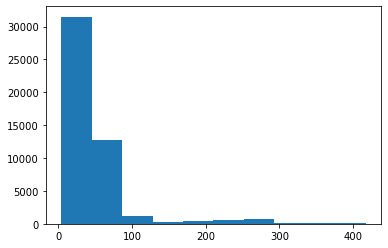

In [11]:
all_cols = [
 'XRefParcel',
 'Address',
 'PropertyClass',
 'PropertyUse',
 'AssessmentArea',
 'MoreThanOneBuild',
 'HomeStyle',
 'YearBuilt',
 'Bedrooms',
 'FullBaths',
 'HalfBaths',
 'TotalLivingArea',
 'FirstFloor',
 'SecondFloor',
 'ThirdFloor',
 'AboveThirdFloor',
 'FinishedAttic',
 'Basement',
 'FinishedBasement',
 'ExteriorWall1',
 'ExteriorWall2',
 'Fireplaces',
 'CentralAir',
 'LotSize',
 'Zoning1',
 'Zoning2',
 'Zoning3',
 'Zoning4',
 'FrontageStreet',
 'WaterFrontage',
 'TIFDistrict',
 'TaxSchoolDist',
 'AttendanceSchool',
 'ElementarySchool',
 'MiddleSchool',
 'HighSchool',
 'RefuseDistrict',
 'AlderDistrict',
 'ExemptionType',
 'FireDistrict',
 'FloodPlain',
 'FuelStorageProximity',
 'HeatingDistrict',
 'LandfillProximity',
 'Landmark',
 'LandscapeBuffer',
 'LocalHistoricalDist',
 'LotDepth',
 'LotNumber',
 'LotType1',
 'LotType2',
 'LotWidth',
 'NationalHistoricalDist',
 'NoiseAirport',
 'NoiseRailroad',
 'NoiseStreet',
 'OwnerChangeDate',
 'OwnerOccupied',
 'ParcelChangeDate',
 'PoliceDistrict',
 'PoliceSector',
 'RailroadFrontage',
 'SenateDistrict',
 'SupervisorDistrict',
 'TotalDwellingUnits',
 'ZoningAll',
 'UrbanDesignDistrict',
 'StreetID',
 'MaxConstructionYear',
 'XCoord',
 'YCoord',
 'SHAPESTArea',
 'SHAPESTLength']
len(all_cols)

73

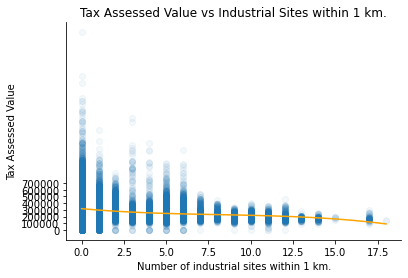

In [127]:

core_fam_reasonable =  core_fam[core_fam["Total_Assessment"] > 75000]
core_fam_reasonable = core_fam_reasonable[core_fam_reasonable["Total_Assessment"] < 750000]


coef = np.polyfit(core_fam["industrial_sites_near"].values, core_fam["Total_Assessment"].values, deg=3)
poly = np.poly1d(coef)
prediction_Xs = np.linspace(0, 18, 50)
y_pred = poly(prediction_Xs)


fig, ax = plt.subplots()
ax.set_yticks([0, 100000, 200000, 300000, 400000, 500000, 600000, 700000])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_title("Tax Assessed Value vs Industrial Sites within 1 km.")
ax.set_ylabel("Tax Assessed Value")
ax.set_xlabel("Number of industrial sites within 1 km.")
ax.scatter(core_fam["industrial_sites_near"], core_fam["Total_Assessment"], alpha=0.05)
ax.plot(prediction_Xs, y_pred, color="orange")
fig.savefig("groop_smol.png", dpi=300)


In [108]:
#core_fam["Total_Assessment"]
core_fam[core_fam["Total_Assessment"].isnull()]

{'70828101067': 0.0, '70828401110': 0.0}
core_fam[]
#core_fam.loc["70828101067"]["Total_Assessment"] = 0.0

XRefParcel                Address PropertyClass    PropertyUse  \
Parcel                                                                         
70828101067  70828101067  9313 Mineral Point Rd   Residential  Single family   
70828401110  70828401110     603 South Point Rd   Residential  Single family   

             AssessmentArea MoreThanOneBuild HomeStyle  YearBuilt  Bedrooms  \
Parcel                                                                        
70828101067             111              NaN       NaN          0         0   
70828401110             125              NaN       NaN          0         0   

             FullBaths  ...       YCoord  SHAPESTArea  SHAPESTLength  \
Parcel                  ...                                            
70828101067          0  ...  477431.1011  26167.11243     662.599434   
70828401110          0  ...  474785.6195  95524.58405    1236.911749   

                   lat        lon       property_kind  industrial_sites_near  \
Parcel                                                                         
70828101067  43.059875 -89.550520  single_family_home                      1   
70828401110  43.052614 -89.552005  single_family_home                      1   

             commercial_sites_near  vacant_sites_near Total_Assessment  
Parcel                                                                  
70828101067                      9                 68              NaN  
70828401110                      6                235              NaN  

[2 rows x 80 columns]

In [138]:
#core = core.drop(columns=["industrial_sites_near", "commercial_sites_near", "vacant_sites_near"])
(all_assessments) = data_retreiver.load_csv_datasets("all_parcel_assessments")

all_assessments = all_assessments[0]
all_assessments["Parcel"] = all_assessments["Parcel"].astype("str")
all_assessments.set_index("Parcel", inplace=True)


assessment_dict = all_assessments["Total_Assessment"].to_dict()

core["Total_Assessment"] = core.index.map(assessment_dict)
core

XRefParcel                 Address PropertyClass  PropertyUse  \
Parcel                                                                        
71002107665  71002104033  121 Metro Ter Unit 109   Residential  Condominium   
71002107673  71002104033  121 Metro Ter Unit 201   Residential  Condominium   
71002107681  71002104033  121 Metro Ter Unit 202   Residential  Condominium   
71002107699  71002104033  121 Metro Ter Unit 203   Residential  Condominium   
71002107706  71002104033  121 Metro Ter Unit 204   Residential  Condominium   
...                  ...                     ...           ...          ...   
71002107615  71002104033  121 Metro Ter Unit 104   Residential  Condominium   
71002107623  71002104033  121 Metro Ter Unit 105   Residential  Condominium   
71002107631  71002104033  121 Metro Ter Unit 106   Residential  Condominium   
71002107649  71002104033  121 Metro Ter Unit 107   Residential  Condominium   
71002107657  71002104033  121 Metro Ter Unit 108   Residential  Condominium   

             AssessmentArea MoreThanOneBuild HomeStyle  YearBuilt  Bedrooms  \
Parcel                                                                        
71002107665            5115              NaN    Garden       2006         2   
71002107673            5115              NaN    Garden       2006         2   
71002107681            5115              NaN    Garden       2006         3   
71002107699            5115              NaN    Garden       2006         1   
71002107706            5115              NaN    Garden       2006         2   
...                     ...              ...       ...        ...       ...   
71002107615            5115              NaN    Garden       2006         2   
71002107623            5115              NaN    Garden       2006         2   
71002107631            5115              NaN    Garden       2006         1   
71002107649            5115              NaN    Garden       2006         1   
71002107657            5115              NaN    Garden       2006         3   

             FullBaths  ...  StreetID  MaxConstructionYear      XCoord  \
Parcel                  ...                                              
71002107665          2  ...      5686                 2006  851889.992   
71002107673          2  ...      5686                 2006  851889.992   
71002107681          2  ...      5686                 2006  851889.992   
71002107699          1  ...      5686                 2006  851889.992   
71002107706          2  ...      5686                 2006  851889.992   
...                ...  ...       ...                  ...         ...   
71002107615          2  ...      5686                 2006  851889.992   
71002107623          2  ...      5686                 2006  851889.992   
71002107631          1  ...      5686                 2006  851889.992   
71002107649          1  ...      5686                 2006  851889.992   
71002107657          2  ...      5686                 2006  851889.992   

                  YCoord  SHAPESTArea  SHAPESTLength        lat        lon  \
Parcel                                                                       
71002107665  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107673  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107681  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107699  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107706  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
...                  ...          ...            ...        ...        ...   
71002107615  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107623  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107631  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107649  492200.3022  189753.7883     1842.05604  43.100414 -89.268753   
71002107657  492200.3022  189753.7883     1842.05604  43.10

In [141]:
core_fam.to_csv("single_family_core.csv")

